In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import equinox
import torch
from locor.gaussian_sampler import GaussianSampler as GaussianSampler_jm
import composable_mapping as cm
import jaxmorph as jm

In [2]:
torch.manual_seed(0)
source_data_test = torch.randn(1, 3, 32, 32, 32)
source_data_test_numpy = source_data_test.numpy()

In [3]:
"""Gaussian smoothing sampler."""

from typing import Sequence, Union

from composable_mapping import (
    LimitDirection,
    PiecewiseKernelDefinition,
    SeparableSampler,
)
from torch import Tensor
from torch import bool as torch_bool
from torch import device as torch_device
from torch import dtype as torch_dtype
from torch import exp, linspace, zeros


class GaussianKernel(PiecewiseKernelDefinition):
    """Gaussian kernel."""

    def __init__(
        self,
        truncate_at: Sequence[int | float],
        mean: Sequence[int | float] | None = None,
        std: Sequence[int | float] | None = None,
    ) -> None:
        self._truncate_at = truncate_at
        self._mean = mean
        self._std = std

    def is_interpolating_kernel(self, spatial_dim: int) -> bool:
        return False

    def edge_continuity_schedule(self, spatial_dim: int, device: torch_device) -> Tensor:
        return zeros(  # Due to truncating, the kernel is not continuous at the edges
            (1, 2), device=device, dtype=torch_bool
        )

    def piece_edges(self, spatial_dim: int, dtype: torch_dtype, device: torch_device) -> Tensor:
        return linspace(
            -self._truncate_at[spatial_dim],
            self._truncate_at[spatial_dim],
            2,
            dtype=dtype,
            device=device,
        )

    def evaluate(self, spatial_dim: int, coordinates: Tensor) -> Tensor:
        std: Union[Tensor, float] = 1.0 if self._std is None else self._std[spatial_dim]
        mean: Union[Tensor, float] = 0.0 if self._mean is None else self._mean[spatial_dim]
        values = exp(-((coordinates - mean) ** 2) / (2 * std**2))
        values = values / values.sum()
        print(values)
        print(values.shape)
        return values


class GaussianSampler(SeparableSampler):
    """Interpolation with gaussian kernel."""

    def __init__(
        self,
        truncate_at: Sequence[int | float],
        mean: Sequence[int | float] | None = None,
        std: Sequence[int | float] | None = None,
    ) -> None:
        self._mean = mean
        self._std = std
        self._truncate_at = truncate_at
        super().__init__(
            kernel=GaussianKernel(truncate_at=truncate_at, mean=mean, std=std),
            extrapolation_mode="zeros",
            mask_extrapolated_regions=False,
            limit_direction=LimitDirection.average(),
        )


tensor([[1.3383e-04, 4.4319e-03, 5.3991e-02, 2.4197e-01, 3.9894e-01, 2.4197e-01,
         5.3991e-02, 4.4319e-03, 1.3383e-04]])
torch.Size([1, 9])
tensor([[1.3383e-04, 4.4319e-03, 5.3991e-02, 2.4197e-01, 3.9894e-01, 2.4197e-01,
         5.3991e-02, 4.4319e-03, 1.3383e-04]])
torch.Size([1, 9])
tensor([[1.3383e-04, 4.4319e-03, 5.3991e-02, 2.4197e-01, 3.9894e-01, 2.4197e-01,
         5.3991e-02, 4.4319e-03, 1.3383e-04]])
torch.Size([1, 9])
torch.Size([1, 3, 32, 32, 32])
-0.0024836468510329723


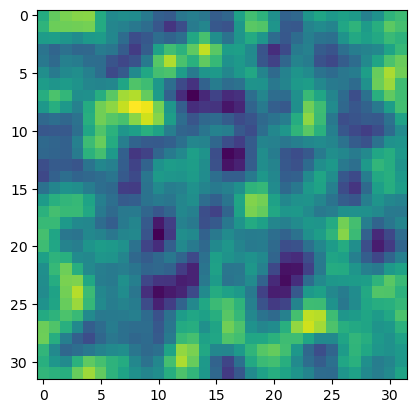

In [4]:
coordinate_system = cm.CoordinateSystem.voxel(
    spatial_shape=source_data_test.shape[2:],
)
source_test = cm.samplable_volume(
    source_data_test,
    coordinate_system=coordinate_system,
    sampler=GaussianSampler(truncate_at=[4, 4, 4]),
)
sampled = source_test.sample().generate_values()
print(sampled.shape)
print(float(sampled.mean()))

plt.imshow(sampled[0, 0, 16])

[[1.3383062e-04 4.4318619e-03 5.3991124e-02 2.4197143e-01 3.9894345e-01
  2.4197143e-01 5.3991124e-02 4.4318619e-03 1.3383062e-04]]
(1, 9)
[[1.3383062e-04 4.4318619e-03 5.3991124e-02 2.4197143e-01 3.9894345e-01
  2.4197143e-01 5.3991124e-02 4.4318619e-03 1.3383062e-04]]
(1, 9)
[[1.3383062e-04 4.4318619e-03 5.3991124e-02 2.4197143e-01 3.9894345e-01
  2.4197143e-01 5.3991124e-02 4.4318619e-03 1.3383062e-04]]
(1, 9)
(1, 3, 32, 32, 32)
-0.002483647782355547


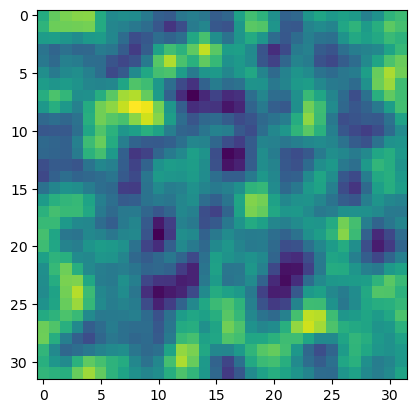

In [5]:
coordinate_system = jm.CoordinateSystem.voxel(
    spatial_shape=source_data_test.shape[2:],
)
source_test = jm.samplable_volume(
    source_data_test_numpy,
    coordinate_system=coordinate_system,
    sampler=GaussianSampler_jm(truncate_at=[4, 4, 4]),
)
sampled = source_test.sample().generate_values()
print(sampled.shape)
print(float(sampled.mean()))
plt.imshow(sampled[0, 0, 16])